# To finetune BERT properly, we need to cleant it and chunk longer sentence

In [2]:
import pandas as pd

data = pd.read_csv("C:\Holmusk\MedicalNotesNLPChallenge\ClinNotes.csv")

In [3]:
set(data['category'])

{'Cardiovascular / Pulmonary', 'Gastroenterology', 'Neurology'}

# Plot the distribution of notes length

<AxesSubplot:>

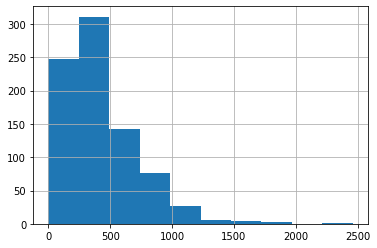

In [6]:
data['notes_len'] = data["notes"].apply(lambda x: len(x.split()))
data['notes_len'].hist()

# Check what percentage of notes are longer than 400 words. I am checking 400 words because when these will be tokenized they will have more than 512 tokens and these extra token will be ignored

In [371]:
sum(data['notes_len']>400)/len(data['notes_len'])*100

44.49877750611247

In [372]:
data['notes_len'].describe()

count     818.000000
mean      430.184597
std       295.495263
min         1.000000
25%       216.000000
50%       366.000000
75%       569.500000
max      2460.000000
Name: notes_len, dtype: float64

In [373]:
data["notes"][0]

'2-D M-MODE: , ,1.  Left atrial enlargement with left atrial diameter of 4.7 cm.,2.  Normal size right and left ventricle.,3.  Normal LV systolic function with left ventricular ejection fraction of 51%.,4.  Normal LV diastolic function.,5.  No pericardial effusion.,6.  Normal morphology of aortic valve, mitral valve, tricuspid valve, and pulmonary valve.,7.  PA systolic pressure is 36 mmHg.,DOPPLER: , ,1.  Mild mitral and tricuspid regurgitation.,2.  Trace aortic and pulmonary regurgitation.'

In [27]:
import re

def clean_text(text):
    # Remove unwanted characters and symbols
    text = re.sub(r"[^A-Za-z0-9., ]+", "", text)
    
    # Split the text into sentences
    sentences = text.split(',')
    
    # Remove leading and trailing spaces from each sentence and remove numbering
    sentences = [re.sub(r"^\d+\.\s*", "", sentence.strip()) for sentence in sentences]
    
    # Remove empty sentences
    sentences = [sentence for sentence in sentences if sentence]
    
    return " ".join(sentences)

data['notes'] = data['notes'].apply(clean_text)
data['notes'][0]


'2D MMODE Left atrial enlargement with left atrial diameter of 4.7 cm. Normal size right and left ventricle. Normal LV systolic function with left ventricular ejection fraction of 51. Normal LV diastolic function. No pericardial effusion. Normal morphology of aortic valve mitral valve tricuspid valve and pulmonary valve. PA systolic pressure is 36 mmHg. DOPPLER Mild mitral and tricuspid regurgitation. Trace aortic and pulmonary regurgitation.'

# Devide notes in multi rows if they are longer than 300 words. Note that i am not chopping off sentences after 300 words. Rather i am chopping from the whole sentence which contain 300th word appers. Doing so helps me to retain context information as much as possible

In [29]:
chunk_size=300

final_df = pd.DataFrame()

def devide(row):
    global final_df
    dev = int(row['notes_len']/chunk_size)
    word_list = row['notes'].split()
    rows = []
    i= 0 
    if len(word_list)<chunk_size:
        one_chunk = " ".join(word_list)
        rows.append(one_chunk)
    else:
        while i<int(row['notes_len']):
            j=-1
            while str(word_list[:i+chunk_size][j])[-1] != '.' and j>-chunk_size:
                j = j-1
            one_chunk = " ".join(word_list[i:i+ chunk_size + j +1])  
            rows.append(one_chunk)
            i = i + chunk_size + j + 1
    
    df = pd.DataFrame({'notes': rows, 'category': row['category'] })
    final_df = final_df.append(df)
    final_df.reset_index(drop=True, inplace=True)

def devide_data(data):
    data.apply(devide, axis=1)
    

In [30]:
devide_data(data)

<ipython-input-29-b185baf03fd8>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(df)


# Save the cleaned and chuncked data

In [31]:
final_df.to_csv("C:\Holmusk\MedicalNotesNLPChallenge\cleaned_chunked_clinic_notes.csv")

# To finetune BERT model based keyword pair we need to first make positive and negative pair

# Now process medical terms to have positive and negative pairs

In [378]:
import pandas as pd

data = pd.read_csv("C:\Holmusk\MedicalNotesNLPChallenge\MedicalConcepts.csv")

In [379]:
data.shape

(566, 2)

In [380]:
data[data.duplicated()]

,Term1,Term2
101,Glaucoma,Fibrillation
135,Seasickness,Ethanol
279,Infertility,Anovulation
360,Hypoproteinemia,Hunger
422,Hyperoxia,Xenical
447,Fibrillation,Angina
456,Drooling,Sinemet
499,Thirsty,Hunger


In [381]:
data.drop_duplicates(keep='first', inplace=True)
data.shape

(558, 2)

In [382]:
import random

#create uniaue set of term2
total_term2_set = set(data['Term1'])
ratio=1
neg = pd.DataFrame()

#provess each unique term1 one by one

for term1 in set(data['Term1']):
    
    #get all term2 related to term1
    right_term2_set = set(data[data['Term1'] == term1]['Term2'])
    
    #get all term2 which do not have pair with term1
    wrtong_set = list(total_term2_set - right_term2_set)
    
    #get how many pair term1 has in total
    p_length=len(right_term2_set)
    
    #sample p terms from wrong set and make pair them with term1 to assign 0 label against it
    wrong_term2 = pd.Series(wrtong_set)[random.sample(range(0, len(wrtong_set)), p_length*ratio)]
    term1 = [term1]*len(wrong_term2)
    negetive = pd.DataFrame({"Term1":term1, "Term2" : wrong_term2})
    #print(negetive)
    neg = neg.append(negetive)


<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future versi

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future versi

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future versi

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future versi

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future versi

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-382-e83e2ca72c27>:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future versi

In [383]:
neg.shape

(558, 2)

In [384]:
data['label']=1
neg['label']=0

In [385]:
final_data = data.append(neg)
final_data.shape

<ipython-input-385-addd0971426b>:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(1116, 3)

In [389]:
final_data.reset_index(drop=True, inplace=True)

In [392]:
final_data.to_csv(r"C:\Holmusk\MedicalNotesNLPChallenge\final_medical_terms.csv")